In [1]:
import sys
import localSettings as ls
print(ls.main_path)

/home/david/data/searchingfornues/v08_00_00_33/cc0pinp/0320/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 03212020


In [4]:
SHRCALIBFACTOR = 1.00

In [5]:
NUE = False

In [6]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
import pandas as pd

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

In [13]:
variables = [
    "shr_dedx_Y", "shr_bkt_pdg", "p", "pt", "selected", "nu_pdg", "shr_theta",
    "slpdg", "trk_score_v", "backtracked_pdg", # modified from shr_score_v
    "shr_pfp_id_v", "category",
    "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
    "shr_tkfit_gap10_dedx_U","shr_tkfit_gap10_dedx_V","shr_tkfit_gap10_dedx_Y",
    "shr_tkfit_2cm_dedx_U","shr_tkfit_2cm_dedx_V","shr_tkfit_2cm_dedx_Y",
    "topological_score",
    #"shr_energy_tot", 
    "trk_energy_tot", "shr_hits_tot", "ccnc", "trk_chipr",
    "trk_bkt_pdg", "hits_ratio", "n_tracks_contained", 
    #"crtveto","crthitpe","_closestNuCosmicDist",
    "NeutrinoEnergy2",
    "ccnc",
    #"run","sub","evt",
    "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
    "nu_flashmatch_score","best_cosmic_flashmatch_score","best_obviouscosmic_flashmatch_score",
    #"trk_pfp_id",
    "shrmoliereavg","shrmoliererms",
    "shr_tkfit_npointsvalid","shr_tkfit_npoints", # fitted vs. all hits for shower
    "shrclusfrac0","shrclusfrac1","shrclusfrac2", # track-fitted hits / all hits
    "trkshrhitdist2", # "trkshrhitdist0","trkshrhitdist1", distance between track and shower in 2D
    "shrsubclusters0","shrsubclusters1","shrsubclusters2", # number of sub-clusters in shower
    "trk_llr_pid_score_v", # trk-PID score
    "trk_energy_proton_v", # track energy under proton hyp
    "trk_calo_energy_y_v", # track calo energy
    #"pi0_energy2_Y", # pi0 tagger variables
    "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
    "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
    "nproton", "nu_e", "n_showers_contained", "shr_distance", "trk_distance",
    "hits_y", "shr_pz", "shr_energy", "shr_dedx_U", "shr_dedx_V", "shr_phi", "trk_phi", "trk_theta",
    "shr_tkfit_dedx_U", "shr_tkfit_dedx_V", "run", "sub", "evt", "nproton", "trk_pid_chipr_v",
    "trk_len", "mc_pdg", "slnunhits", "slnhits", "shr_score", "trk_score", "trk_hits_tot",
    "true_e_visible", "matched_E", "shr_bkt_E", "trk_bkt_E", "trk_energy", "tksh_distance", "tksh_angle",
    "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
    "pi0_e", "shr_energy_tot_cali", "shr_dedx_Y_cali", "evnunhits", "nslice", "interaction",
    "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z","contained_fraction",
    "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","secondshower_Y_dir","shrclusdir2",
    "shr_tkfit_nhits_Y","shr_tkfit_nhits_U","shr_tkfit_nhits_V",
    "shr_tkfit_2cm_nhits_Y","shr_tkfit_2cm_nhits_U","shr_tkfit_2cm_nhits_V",
    "shr_tkfit_gap10_nhits_Y","shr_tkfit_gap10_nhits_U","shr_tkfit_gap10_nhits_V",
    "weightSpline","weightSplineTimesTune","weightTune",
    # pi0 variables
    "pi0_radlen1","pi0_radlen2","pi0_dot1","pi0_dot2","pi0_energy1_Y","pi0_energy2_Y",
    "pi0_dedx1_fit_Y","pi0_dedx2_fit_Y","pi0_shrscore1","pi0_shrscore2","pi0_gammadot",
    "pi0_dedx1_fit_V","pi0_dedx2_fit_V","pi0_dedx1_fit_U","pi0_dedx2_fit_U",
    "pi0_mass_Y","pi0_mass_V","pi0_mass_U",
    "pi0_dir2_x","pi0_dir2_y","pi0_dir2_z","pi0_dir1_x","pi0_dir1_y","pi0_dir1_z"
]

In [8]:
# nue preselection
PRESQ = 'nslice == 1'
PRESQ += ' and selected == 1'
PRESQ += ' and shr_energy_tot_cali > 0.07'
PRESQ += ' and (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20)'

In [9]:
# loose box cuts
NPLCUTQ = PRESQ
NPLCUTQ += ' and n_tracks_contained > 0'
NPLCUTQ += ' and CosmicIPAll3D > 20.'
NPLCUTQ += ' and trkpid < 0.1'
NPLCUTQ += ' and hits_ratio > 0.5'
NPLCUTQ += ' and shr_score < 0.40'
NPLCUTQ += ' and n_showers_contained == 1'
NPLCUTQ += ' and tksh_distance < 6.0'
NPLCUTQ += ' and shr_tkfit_dedx_max < 4.5'
#NPLCUTQ += ' and shr_tkfit_dedx_avg < 4.0'
NPLCUTQ += ' and tksh_angle > -0.9'

In [10]:
# tight box cuts
NPTCUTQ = NPLCUTQ
NPTCUTQ += ' and CosmicIPAll3D > 30.'
NPTCUTQ += ' and CosmicDirAll3D > -0.98 and CosmicDirAll3D < 0.98'
NPTCUTQ += ' and trkpid < 0.02'
NPTCUTQ += ' and hits_ratio > 0.65'
NPTCUTQ += ' and shr_score < 0.25'
NPTCUTQ += ' and shrmoliereavg > 2 and shrmoliereavg < 10'
NPTCUTQ += ' and subcluster > 7'
NPTCUTQ += ' and trkfit < 0.70'
NPTCUTQ += ' and n_showers_contained == 1'
NPTCUTQ += ' and tksh_distance < 4.0'
NPTCUTQ += ' and trkshrhitdist2 < 1.5'
NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_max > 1.0 and shr_tkfit_dedx_max < 3.8)'
#NPTCUTQ += ' and (shr_tkfit_nhits_tot > 1 and shr_tkfit_dedx_avg > 1.0 and shr_tkfit_dedx_avg < 4.0)'
NPTCUTQ += ' and (secondshower_Y_nhit<=8 or secondshower_Y_dot<=0.8 or anglediff_Y<=40 or secondshower_Y_vtxdist>=100)'
NPTCUTQ += ' and secondshower_Y_nhit < 30'
NPTCUTQ += ' and tksh_angle > -0.9 and tksh_angle < 0.70'

In [11]:
# pi0 selection
LOOSE = True
if (LOOSE):
    SCORECUT = 0.8 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  50. # leading photon min energy
    EMIN2 =  20. #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 0.0 # MeV/cm cut on leading shower only
else:
    SCORECUT = 0.5 # 0.75 #75 # max track score
    DVTX = 3.0 # 3. # distance from vertex of each shower
    VTXDOT = 0.8 # dot product between each shower's direction and the vtx -> shr start vector
    EMIN1 =  60. # leading photon min energy
    EMIN2 =  40. #20. # 20. # subleading photon min energy
    GAMMADOT = 0.94 # max dot product between showres
    DEDXCUT = 1.0 # MeV/cm cut on leading shower only

PI0SEL = 'nslice == 1'
PI0SEL += ' & pi0_shrscore1 < %f & pi0_shrscore2 < %f'%(SCORECUT,SCORECUT)
PI0SEL += '& pi0_dot1  > %f & pi0_dot2 > %f '%(VTXDOT,VTXDOT)
PI0SEL += ' & pi0_radlen1 > %f & pi0_radlen2 > %f & pi0_gammadot < %f '%(DVTX,DVTX,GAMMADOT)
PI0SEL += ' & pi0_energy1_Y > %f & pi0_energy2_Y > %f'%(EMIN1,EMIN2)
#PI0SEL += ' and (filter_pi0 == 1 or bnbdata==1 or extdata==1)'
PI0SEL += ' and pi0_dedx1_fit_Y >= %f'%DEDXCUT

In [14]:
fold = "nuselection"
tree = "NeutrinoSelectionFilter"

if (NUE):

    NUECV = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    #NUEWX = "prodgenie_bnb_nue_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    #NUEWYZ = "prodgenie_bnb_nue_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    NUESCE = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_SCE_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    #NUEWAYZ = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleYZ_v08_00_00_38_run3b_reco2_reco2.root"
    #NUEWAXZ = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_WireModAngleXZ_v08_00_00_38_run3b_reco2_reco2.root"
    #DETVAR_N_V = ["WireMod X", "WireMod YZ", 'SCE','WireMod angle YZ', "WireMod Angle XZ"]#,'WireMod X','WireMod YZ']
    DETVAR_N_V = ["SCE"]

    #NUECV = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_CV_reco2_v08_00_00_38_run1_reco2_reco2.root"
    #NUELY = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_LYDown_v08_00_00_37_run1_reco2_reco2.root"
    #NUERY = "prodgenie_bnb_intrinsic_nue_overlay_DetVar_LYRayleigh_v08_00_00_37_run1_reco2_reco2.root"
    #DETVAR_N_V = ["LY Down", "Rayleigh"]#, 'SCE','WireMod angle YZ', "WireMod Angle XZ"]#,'WireMod X','WireMod YZ']
    
    
    DETVAR_S_V = [NUESCE]
    #DETVAR_S_V = [NUELY,NUERY]
    #DETVAR_S_V = [NUEWX,NUEWYZ,NUESCE,NUEWAYZ,NUEWAXZ]#,NUEWX,NUEWYZ]
    
    CV = uproot.open(ls.ntuple_path+NUECV)[fold][tree]
    #CVPOTSUB   = uproot.open(ls.main_path+NUECV)[fold]["SubRun"]
    

else:
    NUMUCV = "prodgenie_bnb_nu_overlay_DetVar_CV_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    NUMULY = "prodgenie_bnb_nu_overlay_DetVar_LYDown_v08_00_00_37_v2_run3b_reco2_reco2.root"
    NUMURY = "prodgenie_bnb_nu_overlay_DetVar_LYRayleigh_v08_00_00_37_run3b_reco2_reco2.root"
    NUMULA = "prodgenie_bnb_nu_overlay_DetVar_LYAttenuation_v08_00_00_38_run3b_reco2_reco2.root"
    NUMUSCE = "prodgenie_bnb_nu_overlay_DetVar_SCE_reco2_v08_00_00_38_run3b_reco2_reco2.root"
    #NUMUR1 = "prodgenie_bnb_nu_uboone_overlay_mcc9_recombination_v08_00_00_33_recomb1_reco2_reco2.root"
    #NUMUR2 = "prodgenie_bnb_nu_uboone_overlay_mcc9_recombination_v08_00_00_33_recomb2_reco2_reco2.root"
    #NUMUR3 = "prodgenie_bnb_nu_uboone_overlay_mcc9_recombination_v08_00_00_33_recomb3_reco2_reco2.root"
    NUMUWAXZ = "prodgenie_bnb_nu_overlay_DetVar_WireModAngleXZ_v08_00_00_38_exe_run3b_reco2_reco2.root"
    NUMUWAYZ = "prodgenie_bnb_nu_overlay_DetVar_WireModAngleYZ_v08_00_00_38_exe_run3b_reco2_reco2.root"
    NUMUWX = "prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaleX_v08_00_00_38_run3b_reco2_reco2.root"
    NUMUWYZ = "prodgenie_bnb_nu_overlay_DetVar_wiremod_ScaleYZ_v08_00_00_38_run3b_reco2_reco2.root"

    DETVAR_N_V = ['LY','Rayleigh',"Attenuation",'SCE',\
                  'WireMod angle XZ',"WireMod angle YZ"\
                 'WireMod X','WireMod YZ']

    DETVAR_S_V = [NUMULY,NUMURY,NUMULA,NUMUSCE,NUMUWAXZ,NUMUWAYZ,NUMUWX,NUMUWYZ]
    
    CV = uproot.open(ls.ntuple_path+NUMUCV)[fold][tree]
    #CVPOTSUB   = uproot.open(ls.ntuple_path+NUMUCV)[fold]["SubRun"]


CVDF  = CV.pandas.df(variables, flatten=False)

#CVPOTDF = CV.pandas.df(['run','sub'],flatten=False)


#CVPOTSUBDF = CVPOTSUB.pandas.df(['run','subRun','pot'],flatten=False)
#CVPOTSUBDF = CVPOTSUBDF.rename(columns={"subRun": "sub","run":"run"})

CVDF['identifier'] = CVDF['run']*100000 + CVDF['evt']

CVDF.loc[ CVDF['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ CVDF['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ CVDF['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
CVDF.loc[ np.isnan(CVDF['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

#'''
trk_llr_pid_v = CV.array('trk_llr_pid_score_v')
trk_energy_proton_v = CV.array('trk_energy_proton_v')
trk_calo_energy_y_v = CV.array('trk_calo_energy_y_v')
trk_id = CV.array('trk_id')-1 # I think we need this -1 to get the right result
trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
CVDF['trkpid'] = trk_llr_pid_v_sel
CVDF['protonenergy'] = trk_energy_proton_sel
CVDF['trackcaloenergy'] = trk_calo_energy_y_sel
CVDF['subcluster'] = CVDF['shrsubclusters0'] + CVDF['shrsubclusters1'] + CVDF['shrsubclusters2']
CVDF['trkfit'] = CVDF['shr_tkfit_npointsvalid'] / CVDF['shr_tkfit_npoints']
CVDF['anglediff_Y'] = np.abs(CVDF['secondshower_Y_dir']-CVDF['shrclusdir2'])
CVDF['shr_tkfit_nhits_tot'] = (CVDF['shr_tkfit_nhits_Y']+CVDF['shr_tkfit_nhits_U']+CVDF['shr_tkfit_nhits_V'])
#CVDF['shr_tkfit_dedx_avg'] = (CVDF['shr_tkfit_nhits_Y']*CVDF['shr_tkfit_dedx_Y'] + CVDF['shr_tkfit_nhits_U']*CVDF['shr_tkfit_dedx_U'] + CVDF['shr_tkfit_nhits_V']*CVDF['shr_tkfit_dedx_V'])/CVDF['shr_tkfit_nhits_tot']
#CVDF['shr_tkfit_2cm_nhits_tot'] = (CVDF['shr_tkfit_2cm_nhits_Y']+CVDF['shr_tkfit_2cm_nhits_U']+CVDF['shr_tkfit_2cm_nhits_V'])
#CVDF['shr_tkfit_2cm_dedx_avg'] = (CVDF['shr_tkfit_2cm_nhits_Y']*CVDF['shr_tkfit_2cm_dedx_Y'] + CVDF['shr_tkfit_2cm_nhits_U']*CVDF['shr_tkfit_2cm_dedx_U'] + CVDF['shr_tkfit_2cm_nhits_V']*CVDF['shr_tkfit_2cm_dedx_V'])/CVDF['shr_tkfit_2cm_nhits_tot']
#CVDF['shr_tkfit_gap10_nhits_tot'] = (CVDF['shr_tkfit_gap10_nhits_Y']+CVDF['shr_tkfit_gap10_nhits_U']+CVDF['shr_tkfit_gap10_nhits_V'])
#CVDF['shr_tkfit_gap10_dedx_avg'] = (CVDF['shr_tkfit_gap10_nhits_Y']*CVDF['shr_tkfit_gap10_dedx_Y'] + CVDF['shr_tkfit_gap10_nhits_U']*CVDF['shr_tkfit_gap10_dedx_U'] + CVDF['shr_tkfit_gap10_nhits_V']*CVDF['shr_tkfit_gap10_dedx_V'])/CVDF['shr_tkfit_gap10_nhits_tot']
CVDF.loc[:,'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_Y']
CVDF.loc[(CVDF['shr_tkfit_nhits_U']>CVDF['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_U']
CVDF.loc[(CVDF['shr_tkfit_nhits_V']>CVDF['shr_tkfit_nhits_Y']) & (CVDF['shr_tkfit_nhits_V']>CVDF['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = CVDF['shr_tkfit_dedx_V']
CVDF["is_signal"] = CVDF["category"] == 11

INTERCEPT = 0.0
SLOPE = 0.83

CVDF["reco_e"] = (CVDF["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + CVDF["trk_energy_tot"]

QUERY = "nslice == 1" #PRESQ #+ " and nu_e < 0.8" # NPTCUTQ # "nslice == 1"

CVDF = CVDF.query(PI0SEL)

print ('there are %i CV events'%(CVDF.shape[0]))

DETSYS_SAMPLE_V = []
POT_V = []

for i,N in enumerate(DETVAR_N_V):
    
    VAR = uproot.open(ls.ntuple_path+DETVAR_S_V[i])[fold][tree]
    VARCVDF = VAR.pandas.df(variables, flatten=False)
    
    #VARPOTDF = VAR.pandas.df(['run','sub'],flatten=False)
    
    # intersect VARPOTDF and CVPOTDF to get appropriate POT
    #INTPOT = pd.merge(CVPOTDF,VARPOTDF,how='inner',on=['run','sub'])
    #print (INTPOT)
    
    #VARPOTSUB   = uproot.open(ls.ntuple_path+DETVAR_S_V[i])[fold]["SubRun"]
    #VARPOTSUBDF = VARPOTSUB.pandas.df(['run','subRun','pot'],flatten=False)
    #VARPOTSUBDF = VARPOTSUBDF.rename(columns={"subRun": "sub","run":"run"})
    
    #POTSUM = np.sum(VARPOTSUBCVDF['pot'].values)
    #print ('POT sum before merge is ',POTSUM)
    
    #INTPOTSUBDF = pd.merge(CVPOTSUBDF,VARPOTSUBDF,how='inner',on=['run','sub'],suffixes=('_DF','_POT'))
    #print (INTPOTSUBDF)
    
    #POTSUM = np.sum(INTPOTSUBCVDF['pot_POT'].values)/2.
    #print ('POT sum after merge is ',POTSUM)
    
    POT_V.append(6e22)
    
    VARCVDF['identifier'] = VARCVDF['run']*100000 + VARCVDF['evt']
    
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ VARCVDF['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    VARCVDF.loc[ np.isnan(VARCVDF['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

    #'''
    trk_llr_pid_v = VAR.array('trk_llr_pid_score_v')
    trk_energy_proton_v = VAR.array('trk_energy_proton_v')
    trk_calo_energy_y_v = VAR.array('trk_calo_energy_y_v')
    trk_id = VAR.array('trk_id')-1 # I think we need this -1 to get the right result
    trk_llr_pid_v_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    VARCVDF['trkpid'] = trk_llr_pid_v_sel
    VARCVDF['protonenergy'] = trk_energy_proton_sel
    VARCVDF['trackcaloenergy'] = trk_calo_energy_y_sel
    VARCVDF['subcluster'] = VARCVDF['shrsubclusters0'] + VARCVDF['shrsubclusters1'] + VARCVDF['shrsubclusters2']
    VARCVDF['trkfit'] = VARCVDF['shr_tkfit_npointsvalid'] / VARCVDF['shr_tkfit_npoints']
    VARCVDF['anglediff_Y'] = np.abs(VARCVDF['secondshower_Y_dir']-VARCVDF['shrclusdir2'])

    VARCVDF['shr_tkfit_nhits_tot'] = (VARCVDF['shr_tkfit_nhits_Y']+VARCVDF['shr_tkfit_nhits_U']+VARCVDF['shr_tkfit_nhits_V'])
    VARCVDF.loc[:,'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_Y']
    VARCVDF.loc[(VARCVDF['shr_tkfit_nhits_U']>VARCVDF['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_U']
    VARCVDF.loc[(VARCVDF['shr_tkfit_nhits_V']>VARCVDF['shr_tkfit_nhits_Y']) & (VARCVDF['shr_tkfit_nhits_V']>VARCVDF['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = VARCVDF['shr_tkfit_dedx_V']

    
    VARCVDF["reco_e"] = (VARCVDF["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + VARCVDF["trk_energy_tot"]
    
    VARCVDF["is_signal"] = VARCVDF["category"] == 11 
    #'''
    
    VARCVDF = VARCVDF.query(PI0SEL)
    
    INT = pd.merge(CVDF, VARCVDF, how='inner', on=['identifier'],suffixes=('_CV', '_VAR'))

    
    print ('intersection for %15s variation has %i events'%(N,INT.shape[0]))
    DETSYS_SAMPLE_V.append(INT)
    
    #break

there are 889 CV events
intersection for              LY variation has 857 events
intersection for        Rayleigh variation has 877 events
intersection for     Attenuation variation has 841 events
intersection for             SCE variation has 455 events
intersection for WireMod angle XZ variation has 718 events
intersection for WireMod angle YZWireMod X variation has 786 events
intersection for      WireMod YZ variation has 681 events


In [15]:
def COVARIANCE(n_cv,n_var):
    cov = np.empty([len(n_cv), len(n_cv)])
    cov.fill(0)

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            cov[i][j] += (n_var[i] - n_cv[i])*(n_var[j] - n_cv[j])

    frac_cov = np.empty([len(n_cv), len(n_cv)])
    corr = np.empty([len(n_cv), len(n_cv)])

    for i in range(len(n_cv)):
        for j in range(len(n_cv)):
            frac_cov[i][j] =  cov[i][j] / (n_cv[i] * n_cv[j])
            corr[i][j] = cov[i][j] / np.sqrt(cov[i][i] * cov[j][j])
    return cov,frac_cov,corr

In [16]:
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 14})


In [17]:
BINS = np.linspace(0.25,1.55,14)
print (BINS)

[0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95 1.05 1.15 1.25 1.35 1.45 1.55]


[ 10.          30.41666667  50.83333333  71.25        91.66666667
 112.08333333 132.5        152.91666667 173.33333333 193.75
 214.16666667 234.58333333 255.         275.41666667 295.83333333
 316.25       336.66666667 357.08333333 377.5        397.91666667
 418.33333333 438.75       459.16666667 479.58333333 500.        ]


/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


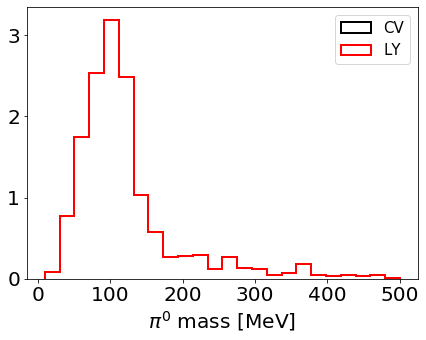

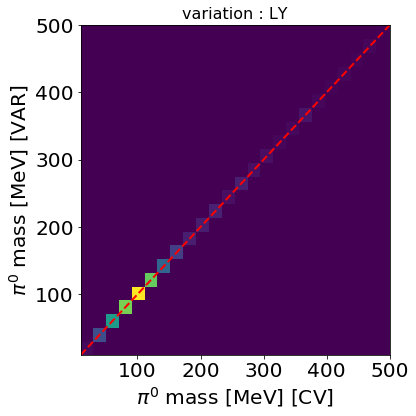

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


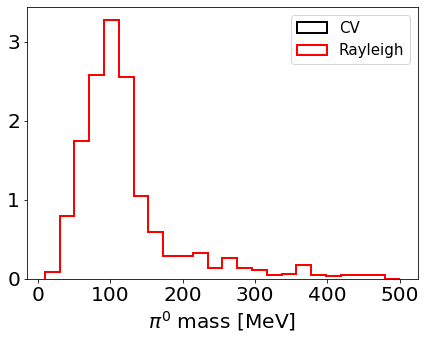

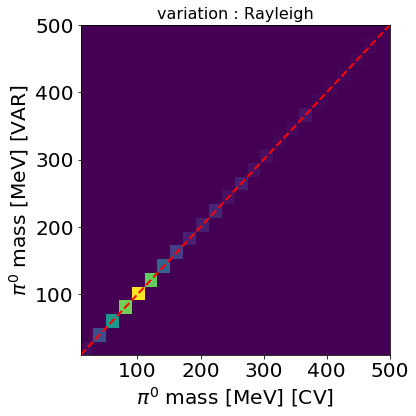

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app


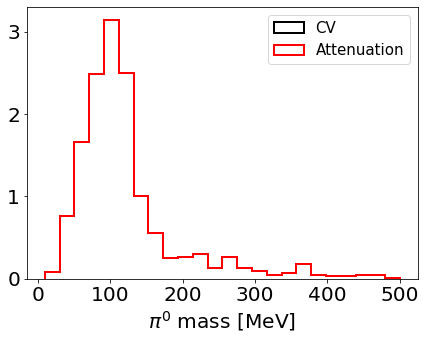

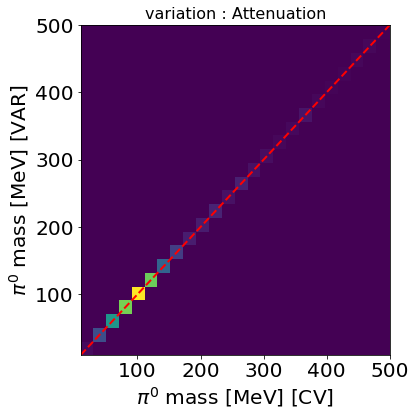

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


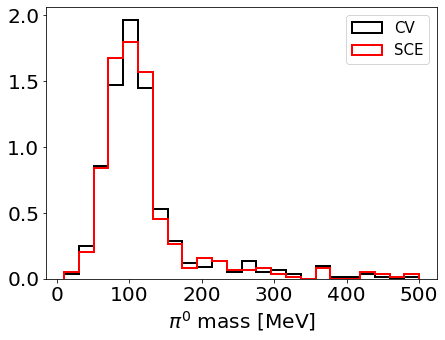

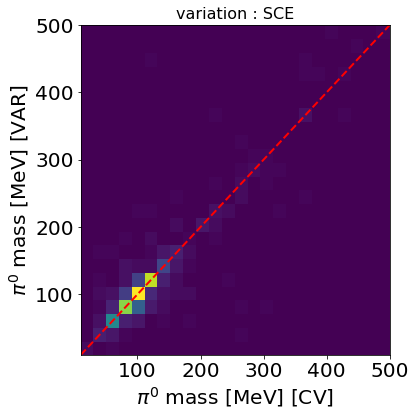

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


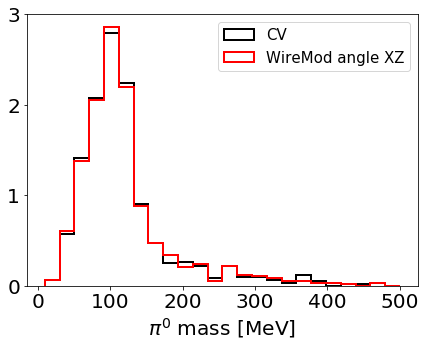

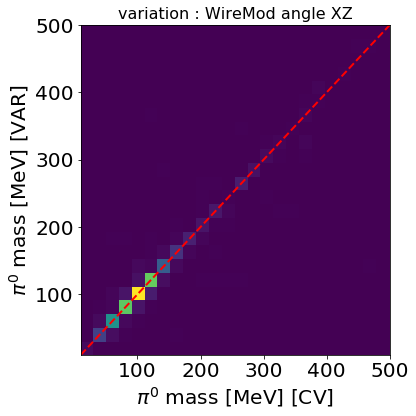

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


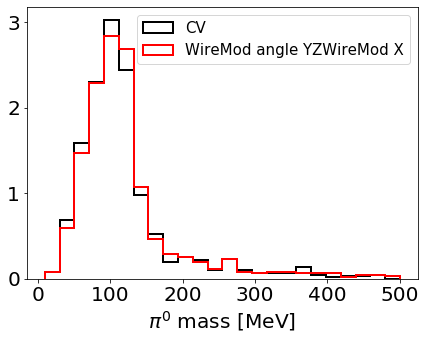

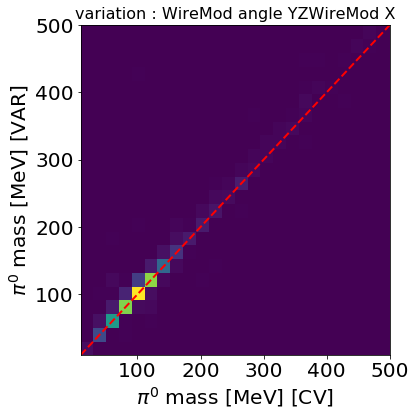

/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  
/home/david/miniconda2/envs/python3LEE/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


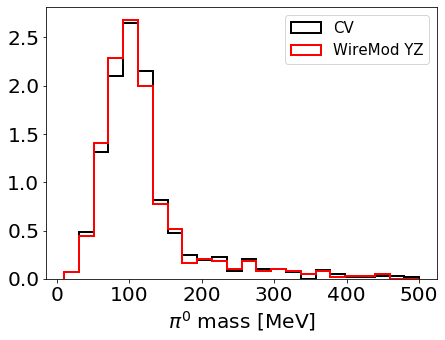

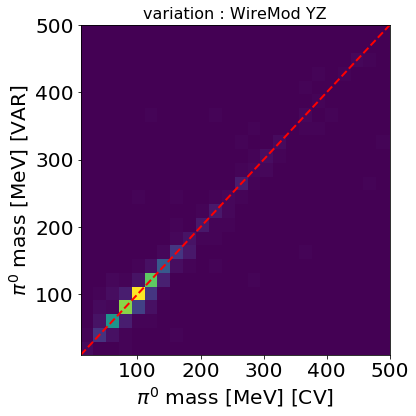

In [19]:
VARIABLE = "pi0_mass_Y"
TITLE = '$\pi^0$ mass [MeV]'
BINS = np.linspace(10,500,25)
print (BINS)

for i,df in enumerate(DETSYS_SAMPLE_V):
    
    #SUBQUERY = ""
    
    dfsub = df#.query(TCUTQ)
    
    #if (i!=1):
    #    continue
    
    #if (i>=6):
    #    continue
    
    #print (df)
    idx = i#+6
    
    SCALE = (1.01e21)/POT_V[i]
    
    fig = plt.figure(figsize=(7,5))
    n_cv, bins, p = plt.hist(dfsub['%s_CV'%VARIABLE] ,bins=BINS,histtype='step',lw=2,color='k',\
             label='CV',weights=dfsub['weightSplineTimesTune_CV']*SCALE)
    n_var, bins, p = plt.hist(dfsub['%s_VAR'%VARIABLE],bins=BINS,histtype='step',lw=2,color='r',\
             label='%s'%DETVAR_N_V[idx],weights=dfsub['weightSplineTimesTune_VAR']*SCALE)
    
    bc = 0.5*(bins[1:]+bins[:-1])
    
    cov,frac_cov,corr = COVARIANCE(n_cv,n_var)
    
    error = np.sqrt(np.diag(frac_cov))
    
    #plt.bar(bc,height=2*(error)*n_cv,bottom=n_cv-(error)*n_cv,width=bc[1]-bc[0] ,\
    #        edgecolor='gray',color='None',lw=2)
    
    plt.xlabel(TITLE)
    #plt.ylabel('Num. Entries',fontsize=16)
    #plt.ylim(0,plt.gca().get_ylim()[1]*1.5)
    plt.legend(fontsize=15,loc="best")
    plt.show()
    fig.savefig(ls.main_path+"plots/"+VARIABLE+"_"+date_time+"_%s"%DETVAR_N_V[idx]+".pdf")
    
    #continue
    
    fig = plt.figure(figsize=(6,6))
    plt.hist2d(dfsub['%s_CV'%VARIABLE],dfsub['%s_VAR'%VARIABLE],bins=(BINS,BINS))#,norm=LogNorm())
    plt.xlabel('%s [CV]'%TITLE)
    plt.ylabel('%s [VAR]'%TITLE)
    plt.title('variation : %s'%DETVAR_N_V[idx],fontsize=16)
    plt.tight_layout()
    plt.plot(BINS,BINS,'r--',lw=2)
    fig.savefig(ls.main_path+"plots/"+VARIABLE+"_corr_"+date_time+"_%s"%DETVAR_N_V[idx]+".pdf")
    #if (i == 0):

    plt.show()
    
    continue
    #print (frac_cov)
            
    fig, ax = plt.subplots(1, 1,figsize=(8,6))
    pos = ax.imshow(frac_cov, origin='lower', cmap='viridis',vmin=-0.1,vmax=0.1)
    ax.set_title("Fractional covariance matrix : %s"%DETVAR_N_V[idx])
    ax.set_ylabel("Bin number")
    ax.set_xlabel("Bin number")
    # Add the text
    # Limits for the extent
    x_start = 0
    x_end = len(n_cv)#-1
    y_start = 0
    y_end = len(n_cv)#-1
    size = len(n_cv)#-1

    x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
    y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

    for x_index, x in enumerate(x_positions):
        #for x_index, x in enumerate(x_positions):
        ERR = frac_cov[x_index, x_index]
        label = "%.01f"%(100.*np.sqrt(ERR))
        text_x = x #+ jump_x
        text_y = x #+ jump_y
        if (np.abs(ERR) > 0.05):
            ax.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
        else:
            ax.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)    
    
    '''
    # open text file where to dump covariance matrix content
    fout = open(ls.main_path+'detsys/'+DETVAR_N_V[idx]+".txt")
    for x_index, x in enumerate(x_positions):
        for y_index, y in enumerate(y_positions):
    
            jump_x = (x_end - x_start) / (2.0 * size)
            jump_y = (y_end - y_start) / (2.0 * size)
            x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
            y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

            for x_index, x in enumerate(x_positions):
                #for x_index, x in enumerate(x_positions):
                ERR = frac_cov[x_index, x_index]
                label = "%.01f"%(100.*np.sqrt(ERR))
                text_x = x #+ jump_x
                text_y = x #+ jump_y
                if (np.abs(ERR) > 0.05):
                    ax.text(text_x, text_y, label, color='black', ha='center', va='center',fontsize=8)
                else:
                    ax.text(text_x, text_y, label, color='white', ha='center', va='center',fontsize=8)
    '''
    
    fig.colorbar(pos)
    fig.savefig(ls.main_path+"noweights/plots/"+VARIABLE+"_matrix_"+date_time+"_%s"%DETVAR_N_V[idx]+".pdf")
    plt.show()

    
    fig, ax = plt.subplots(1, 1)
    ax.set_title("Correlation matrix")
    pos = ax.imshow(corr, origin='lower')
    ax.set_ylabel("Bin number")
    ax.set_xlabel("Bin number")
    fig.colorbar(pos)
    plt.show()


In [ ]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

In [ ]:
QUERYCV = 'nslice_CV == 1'
QUERYVAR = 'nslice_VAR == 1'

VCV = 'nu_e_CV'
VVAR = 'nu_e_VAR'

for i,df in enumerate(DETSYS_SAMPLE_V):
    
    fig = plt.figure(figsize=(6,6))
    
    ACCEPTANCECV = 'ccnc_CV == 0'
    ACCEPTANCEVAR = 'ccnc_VAR == 0'
    
    centers,vals,errs = Eff(df,VCV,QUERYCV,ACCEPTANCECV,BINS)
    plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='k',label=r'CV')
    
    centers,vals,errs = Eff(df,VVAR,QUERYVAR,ACCEPTANCEVAR,BINS)
    plt.errorbar(centers,vals,yerr=errs,fmt='o-',color='r',label=r'%s'%(DETVAR_N_V[i]))
    
    plt.legend()
    
    plt.show()
